<a href="https://colab.research.google.com/github/J-Neff/MAT421/blob/main/MAT421_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NTSB Air Accident Numerical Problem Analysis**
## **Introduction**
The National Transportation Safety Board (NTSB) is the federal organization that investigates accidents and significant events involving aviation, railroad, transit, highway, marine, pipeline, and commercial space in the United States and involved U.S. companies/citizens in other countries [1]. For this project, the total volume of data avaliable via the NTSB's public records is unworkable. As such, some constraints have been used to narrow the focus of the project and the dataset. These include:

**Restricting the event type to ACC (accident).**
The NTSB classifies events as accidents, incidents, and occurances [1]. An accident is classified as an instance in which injury or damage to vehicle has occured or had likely potential to have occured.

**Restricting vehicle category to AIR (airplane).**
For the interests of this project, we only wish to consider aviation vehicles. Within that category we also wish to exclude non-airplane air vehicles (i.e. hot air balloons, gliders, etc.).

**Restricting FAR category (Federal Aviation Requirements) to Part 121 (Regularly Scheduled Air Carriers)[2].**
This constraint serves multiple purposes. Firstly, we only wish to provide analysis of commercial flight accidents for this project. Secondly, this category provides a distinction in type of aircraft. All amateur aircraft are excluded from this category, which when included could cause a problem in regards to the analysis of aircraft weight, maintenance, and pilot skill. Restricting to this FAR category also provides better insight to the intended audience, which is the general public who might be interested in the safety of commercial flight.

**Using only closed accident reports**.
This makes sure data is only included from concluded investigations as there are many that are still ongoing and do not have usable data due to that status. Closed accident reports include investigations in which a report was not created (for the most part investigations in foreign countries) or has been completed.

##**Source of Data**
As a federal organization, the NTSB data on completed investigations must be avaliable to the public. Via the internet the NTSB provides CAROL (Case Analysis and Reporting Online) as a means of accessing information[3]. Within CAROL, the Aviation Investigation Search includes all public aviation accidents from 1962 to present. These include all incidents in which United States territory or citizens are involved. In addition, the NTSB is often asked to consult on international cases to share investigative skill, technique, or technology especially for countries with less established air investigation teams.

Once the previously stated constraints were entered as a custom search, the results of the search were downloaded as a CSV file. For ease of visualization, this CSV file was then imported into a Google Sheet file. This file will be used as the dataset for this project. No changes were made between the search, download as CSV, and import into Sheets.

## **Problems to Consider**
The problems to be considered in this project address:


1.   Likelyhood of accident by airline, aircraft make, location, date, and weather.
2.   Severity of accident by airline, aircraft make, location, date, and weather.
3.   Predictive analysis of accidents for 2030.
4.   Length of time between accident and investigation completion analysed by severity, airline, aircraft make, location, and weather.

Modeling will be done using python's built-in tools, graphing, charts, and predictive tools.

## **Expectations**
The expectations of this project is to provide data analysis and graphics that would be useful to a traveler in determining the airline, airplane model, location, and weather in which they wish to travel. This project will also predict factors influencing the future safety of airline travel.







##**Prepare Data**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import datetime as dt
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
data = 'https://docs.google.com/spreadsheets/d/1kyd3T7N7QrAQ6UDe9sLYgMo8dvDdxu8ZUbcS6W2sA3Q/export?format=csv'
df = pd.read_csv(data, keep_default_na=False)
name = df.City + " ," + df.State + " ," + df.Country;

##**Initial Statistics**

**Raw Data Display**

In [2]:
df.head()

,NtsbNo,EventType,Mkey,EventDate,City,State,Country,ReportNo,N,HasSafetyRec,...,Scheduled,PurposeOfFlight,FAR,AirCraftDamage,WeatherCondition,Operator,ReportStatus,RepGenFlag,DocketUrl,DocketPublishDate
0,DCA82AA011,ACC,79455,1982-01-13T05:00:00Z,WASHINGTON,District of Columbia,United States,AAR8208,N62AF,True,...,SCHD,UNK,121,Destroyed,IMC,AIR FLORIDA,Completed,True,,
1,DCA82AA028,ACC,79465,1982-07-09T04:00:00Z,NEW ORLEANS,Louisiana,United States,AAR8302,N4737,True,...,SCHD,UNK,121,Destroyed,VMC,PAN AMERICAN WORLD AIRWAYS,Completed,True,,
2,DCA19WA021,ACC,98608,2018-11-07T10:05:00Z,Halifax,,Canada,,N908AR,False,...,NSCH,,121,Substantial,,,N/A,False,,
3,DCA18WA027,ACC,96408,2017-11-29T05:00:00Z,Bogota,,Colombia,,N14115,False,...,SCHD,,121,None,,,N/A,False,,
4,DCA17WA154,ACC,95625,2017-07-01T04:10:00Z,Fukushima,,Japan,,N29968,False,...,SCHD,,121,None,,,N/A,False,,


To start, this dataframe provides several columns of unnecessary data. The NtsbNo is unneeded, the EventType is one of the constraints so all of its datapoints are the same (ACC), no specific reports are referenced so the ReportNo is left unutilized. These are only some of the unused columns. Out of the 37 columns, this project uses 13. Out of those 37, 5 are also determined entirely by the categorization of this project, i.e. ReportStatus is either "Completed" or "n/a".

**Severity**

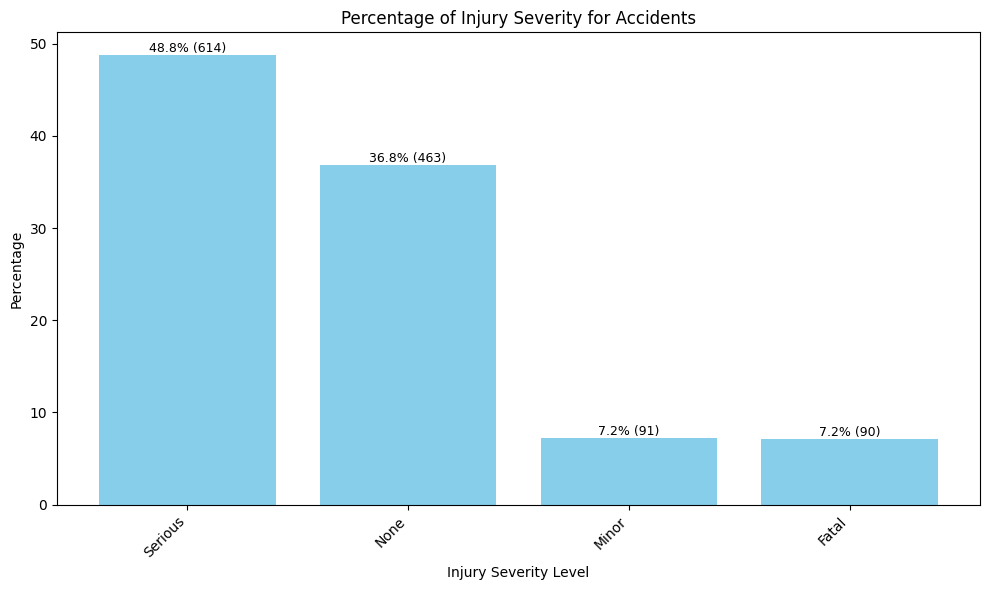

In [3]:
# Clean Data
df['HighestInjuryLevel'] = df['HighestInjuryLevel'].replace('', np.nan)
df = df.dropna(subset=['HighestInjuryLevel'])

# Calculate
injury_counts = df['HighestInjuryLevel'].value_counts()
injury_percentages = injury_counts / len(df) * 100
injury_df = pd.DataFrame({
    'Injury_Level': injury_percentages.index,
    'Percentage': injury_percentages.values
})
injury_df['Injury_Level'] = pd.Categorical(injury_df['Injury_Level'], categories=["None", "Minor", "Serious", "Fatal"])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(injury_df['Injury_Level'].astype(str), injury_df['Percentage'], color='skyblue')
for i, val in enumerate(injury_df['Percentage']):
    plt.text(i, val, f"{round(val, 1)}% ({injury_counts[i]})", ha='center', va='bottom', fontsize=9)
plt.title("Percentage of Injury Severity for Accidents")
plt.xlabel("Injury Severity Level")
plt.ylabel("Percentage")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This data shows that in all accidents the majority of them resulted in the highest injury level being serious or none. By FAA regulations a “Serious injury means any injury which: (1) Requires hospitalization for more than 48 hours, commencing within 7 days from the date of the injury was received; (2) results in a fracture of any bone (except simple fractures of fingers, toes, or nose); (3) causes severe hemorrhages, nerve, muscle, or tendon damage; (4) involves any internal organ; or (5) involves second- or third-degree burns, or any burns affecting more than 5 percent of the body surface”[6]. Bear in mind that the category is "Highest Injury Level" meaning that incidents like Delta Airlines 860 [NtsbNo = DCA21LA018]: in which brief turbulence caused a flight attendant to fall and fracture a rib, resulting in one serious injury and 251 non-injuries, are classified as serious in this category. Hence the data shows that based on accident data 48.8% of accidents result in at least one serious injury and 36.8% of accidents result in everyone on the aircraft being completely uninjured.

**Map**

<ipython-input-4-dab52fb8de70>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


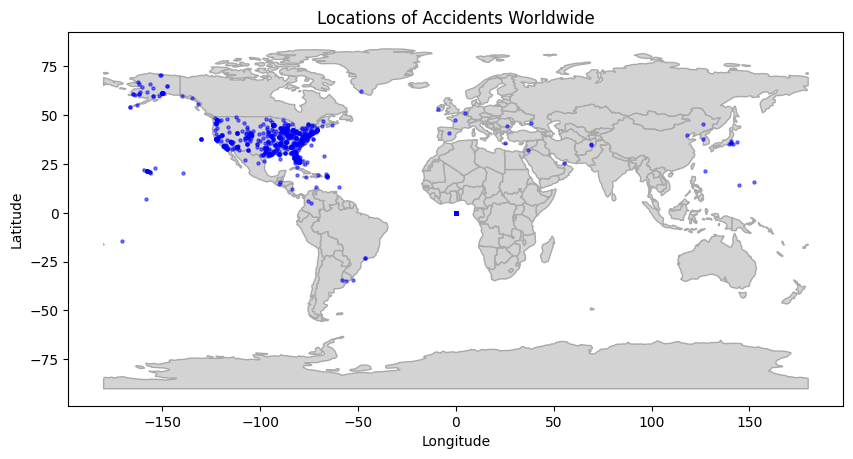

In [4]:
# Format
location_data = df.dropna(subset=['Latitude', 'Longitude'])
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_location_data = gpd.GeoDataFrame(location_data,
                                      geometry=gpd.points_from_xy(location_data.Longitude, location_data.Latitude))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
world_map.plot(ax=ax, color='lightgray', edgecolor='darkgray')
geo_location_data.plot(ax=ax, color='blue', markersize=5, label='Accidents', alpha=0.5)
ax.set_title('Locations of Accidents Worldwide')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

This map displays the clustering of NTSB investigated accidents. Without the knowledge that the data is solely from the NTSB, the world map would be misleading. The NTSB only investigates accidents in which United States companies are involved or on US territory. The NTSB is also occasionally asked to assist in investigations in other countries. Hence, the clustering around the US of accidents is simply because of the NTSB's jurisdiction.

## **Problem 1**
**Likelyhood of Accident by Airline**


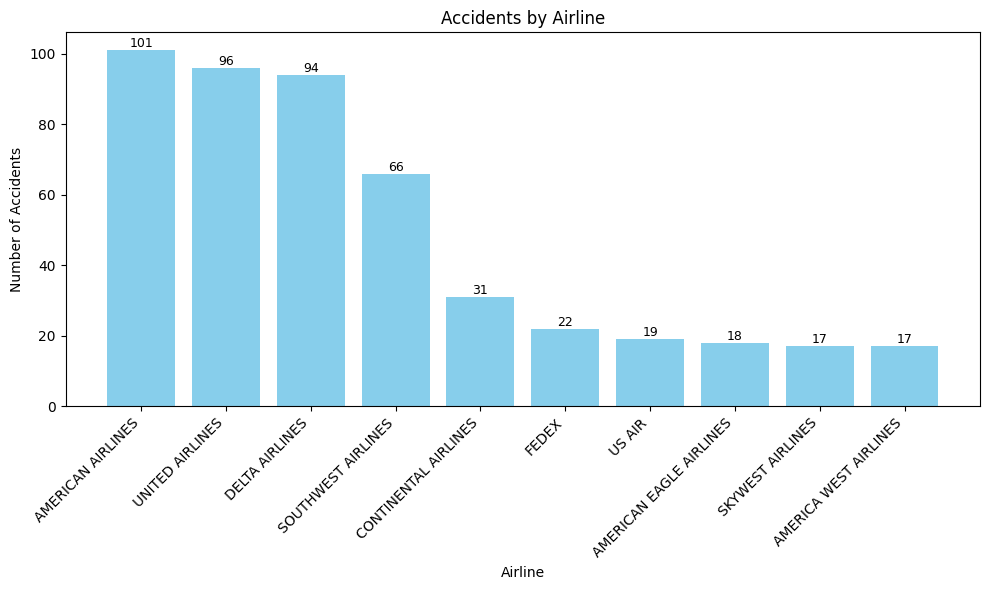

In [5]:
# Clean
acc_airline = df.dropna(subset=['Operator'])
acc_airline['Operator'] = acc_airline['Operator'].str.strip()
acc_airline = acc_airline.assign(Operator=acc_airline['Operator'].str.split(', ')).explode('Operator')
acc_airline = acc_airline[~acc_airline['Operator'].str.match(r'^\d+$')]

# Calculate
accidents_by_airline = acc_airline['Operator'].value_counts().reset_index()
accidents_by_airline.columns = ['Operator', 'Number of Accidents']
accidents_by_airline = accidents_by_airline[(accidents_by_airline['Number of Accidents'] >= 17) &
                                            (accidents_by_airline['Operator'] != '')]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_airline['Operator'], accidents_by_airline['Number of Accidents'], color='skyblue')
for i, val in enumerate(accidents_by_airline['Number of Accidents']):
    plt.text(i, val, f"{val}", ha='center', va='bottom', fontsize=9)
plt.title("Accidents by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This graph shows that American Airlines has had the most accidents historically. Many of the larger, more well known airlines have had the majority of accidents because of fleet size factors. The larger the fleet, the more airplanes operating, hence the more likely there will be an accident.
It is also important to consider that airlines come and go and merge. Continental merged with United in 2012. US Air rebranded to US Airways in 1997, then merged with American Airlines in 2013. American Eagle Airlines is a subsidiary of American Airlines. American West Airlines merged with US Airways in 2007. Please note, this has not resulted in any double counting as the operator is listed by who owned the plane at the time.

**History of Accidents by Aircraft Make**

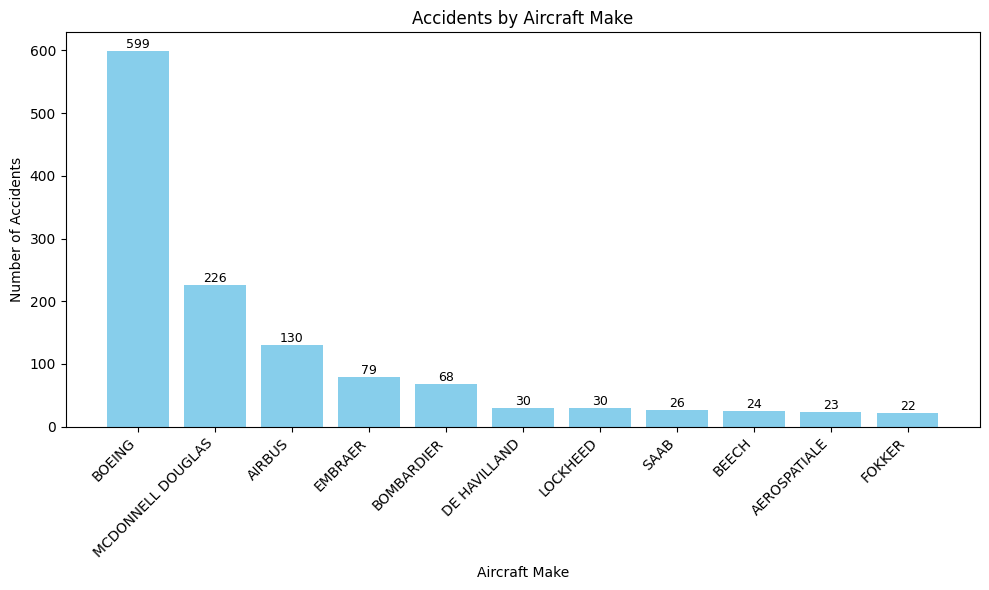

In [6]:
# Clean
air_make = df.dropna(subset=['Make'])
air_make['Make'] = air_make['Make'].str.strip()
air_make = air_make.assign(Make=air_make['Make'].str.split(', ')).explode('Make')

# Calculate
accidents_by_make = air_make['Make'].value_counts().reset_index()
accidents_by_make.columns = ['Make', 'Number of Accidents']
accidents_by_make = accidents_by_make[accidents_by_make['Number of Accidents'] >= 22]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_make['Make'], accidents_by_make['Number of Accidents'], color='skyblue')
for i, val in enumerate(accidents_by_make['Number of Accidents']):
    plt.text(i, val, f"{val}", ha='center', va='bottom', fontsize=9)
plt.title("Accidents by Aircraft Make")
plt.xlabel("Aircraft Make")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Boeing is the most common aircraft make in the United States, and therefore makes up the largest number of aircraft in accidents. Many of the larger airlines also sign exclusive contracts with manufacturers and only have airplanes of that make. Similar to the operators, quite a few of these manufacturers have gone out of buisness or merged. McDonnell Douglas merged with Boeing in 1997 (though it still produces military aircraft under that name). De Havilland, through a series of mergers became part of BAE Systems. Lockheed became Lockheed Martin and stopped producing civilian aircraft in 1995. The majority of Aérospatiale's assets are now part of Airbus. Fokker went bankrupt in 1996.

**History of Accidents by Location (USA)**

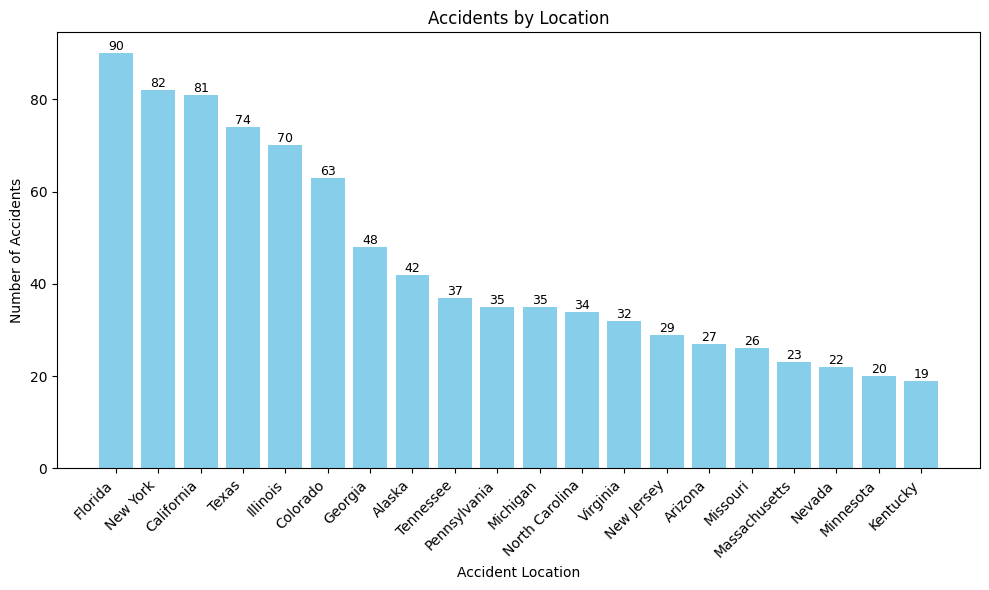

In [7]:
# Clean
acc_location = df.dropna(subset=['State'])
acc_location['State'] = acc_location['State'].str.strip()
acc_location = acc_location.assign(State=acc_location['State'].str.split(', ')).explode('State')
acc_location = acc_location[acc_location['State'] != '']

# Calculate
accidents_by_location = acc_location['State'].value_counts().reset_index()
accidents_by_location.columns = ['State', 'Number of Accidents']
accidents_by_location = accidents_by_location[accidents_by_location['Number of Accidents'] >= 19]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_location['State'], accidents_by_location['Number of Accidents'], color='skyblue')
for i, val in enumerate(accidents_by_location['Number of Accidents']):
    plt.text(i, val, f"{val}", ha='center', va='bottom', fontsize=9)
plt.title("Accidents by Location")
plt.xlabel("Accident Location")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In the US, extremely populated states, such as Florida, New York, and California have had more accidents. In addition, New York and California are home to some of the most busy airports in the world.

**History of Accidents by Date**

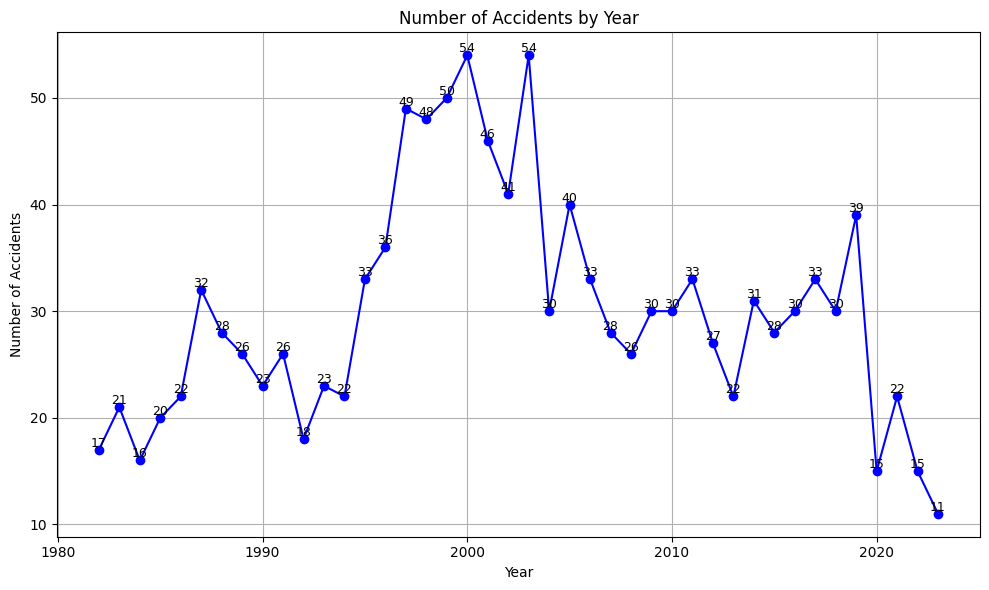

In [8]:
# Clean
df['EventDate'] = pd.to_datetime(df['EventDate'], format="%Y-%m-%dT%H:%M:%SZ")
df['Year'] = df['EventDate'].dt.year

# Calculate
accidents_by_year = df['Year'].value_counts().sort_index()
accidents_df = pd.DataFrame({'Year': accidents_by_year.index, 'Accidents': accidents_by_year.values})

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(accidents_df['Year'], accidents_df['Accidents'], marker='o', color='blue', linestyle='-')
for i, val in accidents_df.iterrows():
    plt.text(val['Year'], val['Accidents'], f"{int(val['Accidents'])}", va='bottom', ha='center', fontsize=9)
plt.title("Number of Accidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

From 1882 to 2023, we can observe a peak in accidents from about 1995 to 2005. As a whole, there are quite a few likely reasons for this, one of which is the 1981 Air Traffic Controller strike. This strike resulted in President Ronald Reagan firing more than 11 thousand controllers. The rammifications of this was a general decline in the numbers of ATC as well as the original reasons for the strike left unaddressed, many of which involved safety concerns. In addition, this period of time coinsided with the peak of airtravel, with lower fares and higher passenger capacity on aircraft.

**History of Accidents by Weather**

Weather is classified in two types by the NTSB: VMC (Visual Meteorological Conditions) and IMC (Instrument Meteorological Conditions). VMC are conditions in which pilots have sufficient visibility to fly the aircraft maintaining visual separation from terrain and other aircraft. IMC is the opposite, in which pilots must rely on instruments to fly safely. These conditions vary by many factors, but for the most part IMC is defined by poor weather conditions such as: heavy cloud cover or fog, nighttime, heavy rain, hail, or snow[5]. It is fairly easy to assume that IMC are more likely to result in accidents, but it is important to show exactly how likely that would be.

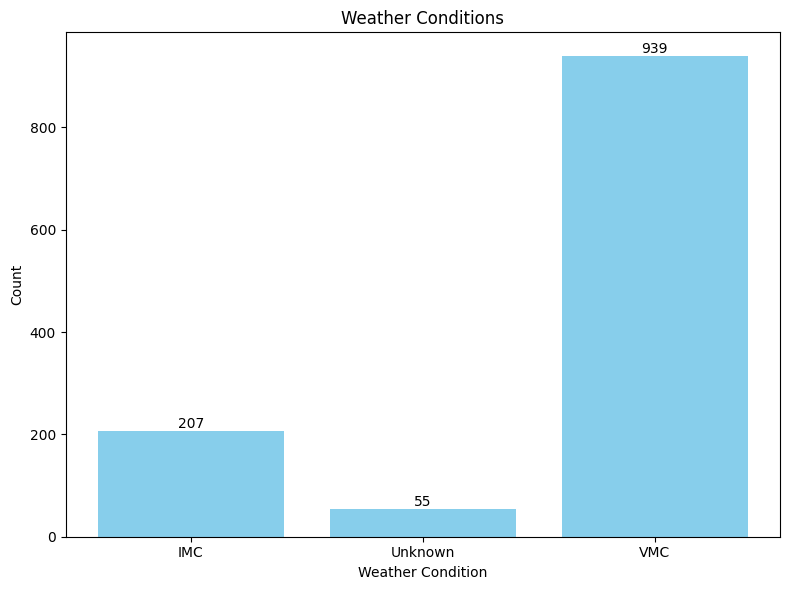

In [9]:
# Clean
weather_df = df[df['WeatherCondition'].notna()]

# Calculate
weather_counts = weather_df['WeatherCondition'].value_counts().reset_index(name='Count')
weather_levels = ["Unknown", "VMC", "IMC"]
weather_df = weather_counts[weather_counts['WeatherCondition'].isin(weather_levels)]
weather_df = weather_df.sort_values(by=['WeatherCondition'])

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(weather_df['WeatherCondition'], weather_df['Count'], color='skyblue')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.title('Weather Conditions')
for i, v in enumerate(weather_df['Count']):
  plt.text(i, v + 0.1, str(v), va='bottom', ha='center')
plt.tight_layout()
plt.show()

Here we can see that the typical assumption is wrong. Accidents are more common in VMC. This is because of a fundamental misunderstanding in the public's understanding of pilot training and protocol. Pilots are taught to trust thier instruments over their instincts in IMC, and machines are far less fallible than people.

## **Problem 2**
**Severity of Accident by Airline**


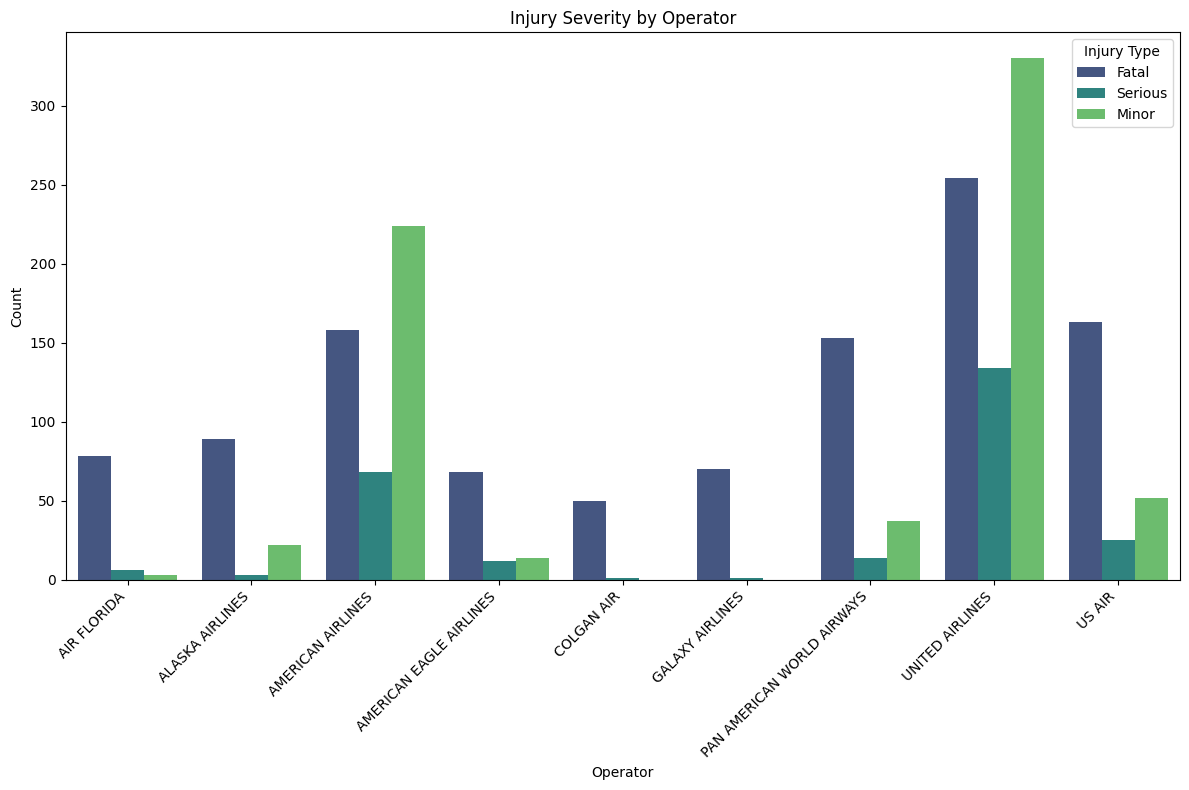

In [10]:
# Clean
acc_airline = df.dropna(subset=['Operator'])

# Calculate
sev_airline_total = acc_airline.groupby('Operator').agg(
    TotalInjuries=('FatalInjuryCount', 'sum')
)
filter_operators = sev_airline_total.nlargest(10, 'TotalInjuries').index
acc_airline_filtered = acc_airline[acc_airline['Operator'].isin(filter_operators)]
sev_airline = acc_airline_filtered.groupby('Operator').agg(
    Fatal=('FatalInjuryCount', 'sum'),
    Serious=('SeriousInjuryCount', 'sum'),
    Minor=('MinorInjuryCount', 'sum')
)
sev_airline = sev_airline[(sev_airline.T != 0).any()]
sev_airline_long = sev_airline.reset_index().melt(id_vars='Operator', var_name='InjuryType', value_name='Count')
sev_airline_long_filtered = sev_airline_long[sev_airline_long['Operator'].str.strip() != ""]

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=sev_airline_long_filtered, x='Operator', y='Count', hue='InjuryType', palette='viridis')
plt.title('Injury Severity by Operator')
plt.xlabel('Operator')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Injury Type')
plt.tight_layout()
plt.show()

From this graph, we can see that United Airlines has the most severe accidents, followed by American Airlines. United has the largest total number of minor, serious, and fatal injuries in accidents. Here there also needs to be a caveat for United Airlines and American Airlines given the purposeful nature of the 109 (United) and 156 (American) fatalities on September 11, 2001. These are outliers in that the result of these flights were not accidental. However, with these fatalities subtracted both United and American remain in the top two spots.

**Severity of Accident by Aircraft Make**

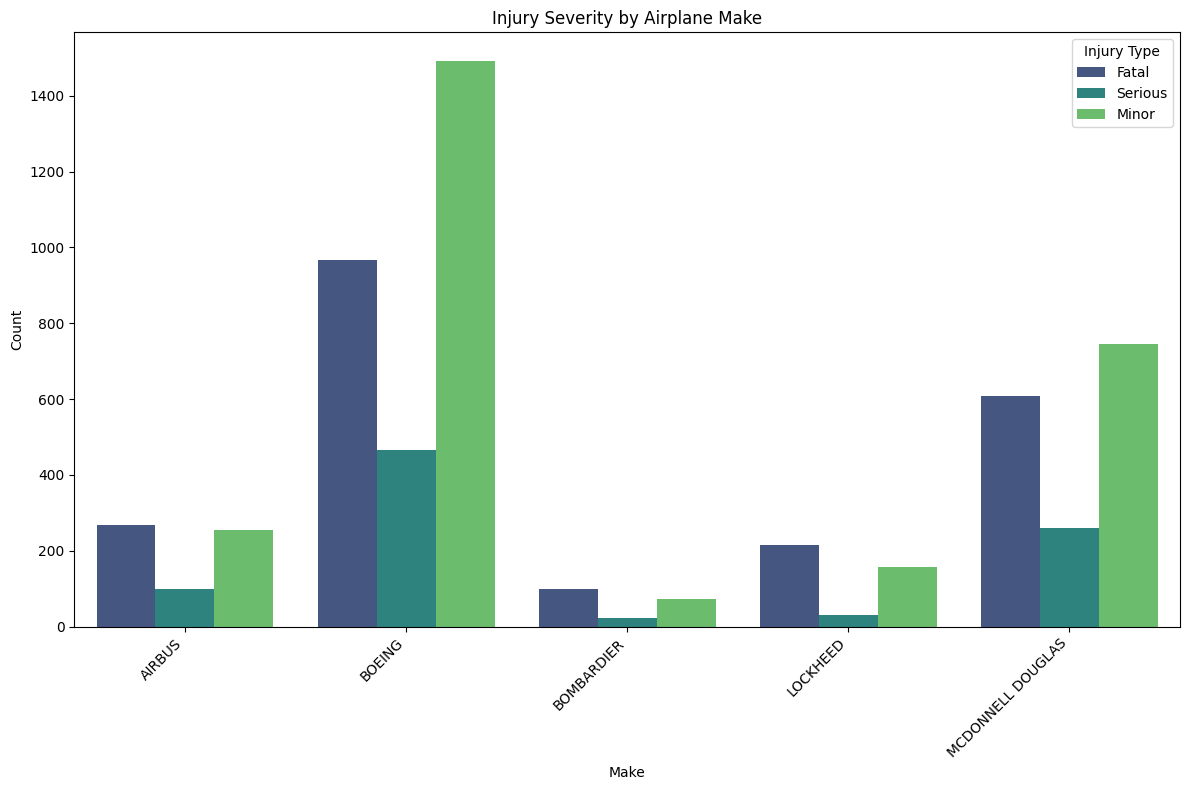

In [11]:
# Clean
air_make = df.dropna(subset=['Make'])

# Calculate
sev_make_total = air_make.groupby('Make').agg(
    TotalInjuries=('FatalInjuryCount', 'sum')
)
top_makes = sev_make_total.nlargest(5, 'TotalInjuries').index
air_make_filtered = air_make[air_make['Make'].isin(top_makes)]
sev_make = air_make_filtered.groupby('Make').agg(
    Fatal=('FatalInjuryCount', 'sum'),
    Serious=('SeriousInjuryCount', 'sum'),
    Minor=('MinorInjuryCount', 'sum')
)
sev_make = sev_make[(sev_make.T != 0).any()]
sev_make_long = sev_make.reset_index().melt(id_vars='Make', var_name='InjuryType', value_name='Count')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=sev_make_long, x='Make', y='Count', hue='InjuryType', palette='viridis')
plt.title('Injury Severity by Airplane Make')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Injury Type')
plt.tight_layout()
plt.show()

Boeing aircraft tend to have the most severe accidents. This can be partially explained by the fact that both American Airlines and United Airlines operate Boeing fleets, with the same caveats as the previous. But Boeing also has a track record of safety concerns and failing FAA safety checks.

**Severity of Accident by Location**

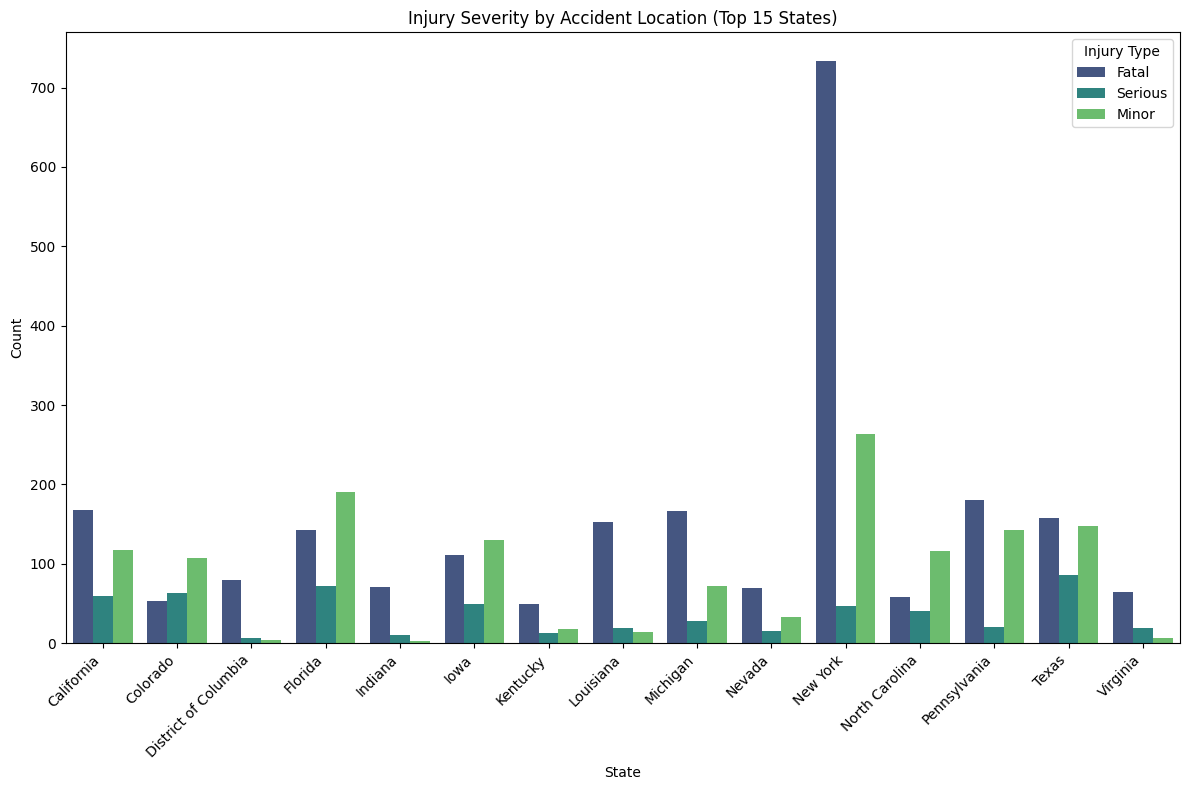

In [12]:
# Clean
acc_location = df.dropna(subset=['State'])

# Calculate
sev_location_total = acc_location.groupby('State').agg(
    TotalInjuries=('FatalInjuryCount', 'sum')
)
top_states = sev_location_total.nlargest(15, 'TotalInjuries').index
acc_location_filtered = acc_location[acc_location['State'].isin(top_states)]
sev_location = acc_location_filtered.groupby('State').agg(
    Fatal=('FatalInjuryCount', 'sum'),
    Serious=('SeriousInjuryCount', 'sum'),
    Minor=('MinorInjuryCount', 'sum')
)
sev_location = sev_location[(sev_location.T != 0).any()]
sev_location_long = sev_location.reset_index().melt(id_vars='State', var_name='InjuryType', value_name='Count')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=sev_location_long, x='State', y='Count', hue='InjuryType', palette='viridis')
plt.title('Injury Severity by Accident Location (Top 15 States)')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Injury Type')
plt.tight_layout()
plt.show()

Overwhelmingly, the state with the largest number of severe accidents is New York. There are many reasons for this, mainly the country's largest airports are located in New York and that there is not a lot of empty space for a plane to land, should it need to make an emergency landing. Once again with the previous caveats, New York still remains with the most fatal accidents.

**Severity of Accident by Date**

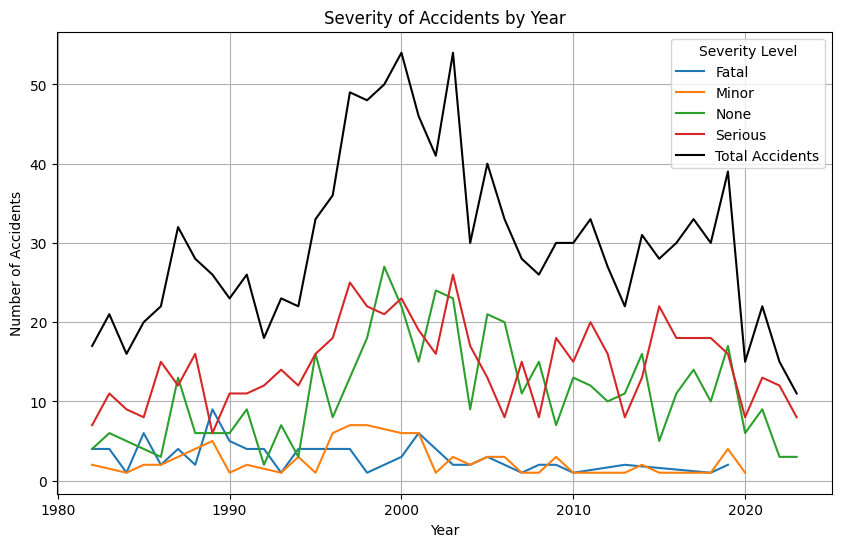

In [13]:
# Clean
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y-%m-%dT%H:%M:%SZ')
df['Year'] = df['EventDate'].dt.year

# Calculate
severity_counts = df.groupby(['Year', 'HighestInjuryLevel']).size().reset_index(name='AccidentCount')
total_accidents = severity_counts.groupby('Year')['AccidentCount'].sum().reset_index(name='TotalAccidents')
severity_counts = severity_counts.dropna(subset=['HighestInjuryLevel'])

# Plotting
plt.figure(figsize=(10, 6))
for level in severity_counts['HighestInjuryLevel'].unique():
    data = severity_counts[severity_counts['HighestInjuryLevel'] == level]
    plt.plot(data['Year'], data['AccidentCount'], label=level)
plt.plot(total_accidents['Year'], total_accidents['TotalAccidents'], color='black', label='Total Accidents')

plt.title('Severity of Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Level')
plt.grid(True)
plt.show()

Here it can be seen, that overall, fatal accidents are rather rare over the years. It is much more likely historically for accidents to result in no injuries or severe but survivable injuries. In addition, fatal injuries have continued to decline over time. Each time there is a fatality, new regulations are created to prevent fatalities of that same nature again. This is a widely successful strategy.

**Severity of Accident by Weather**

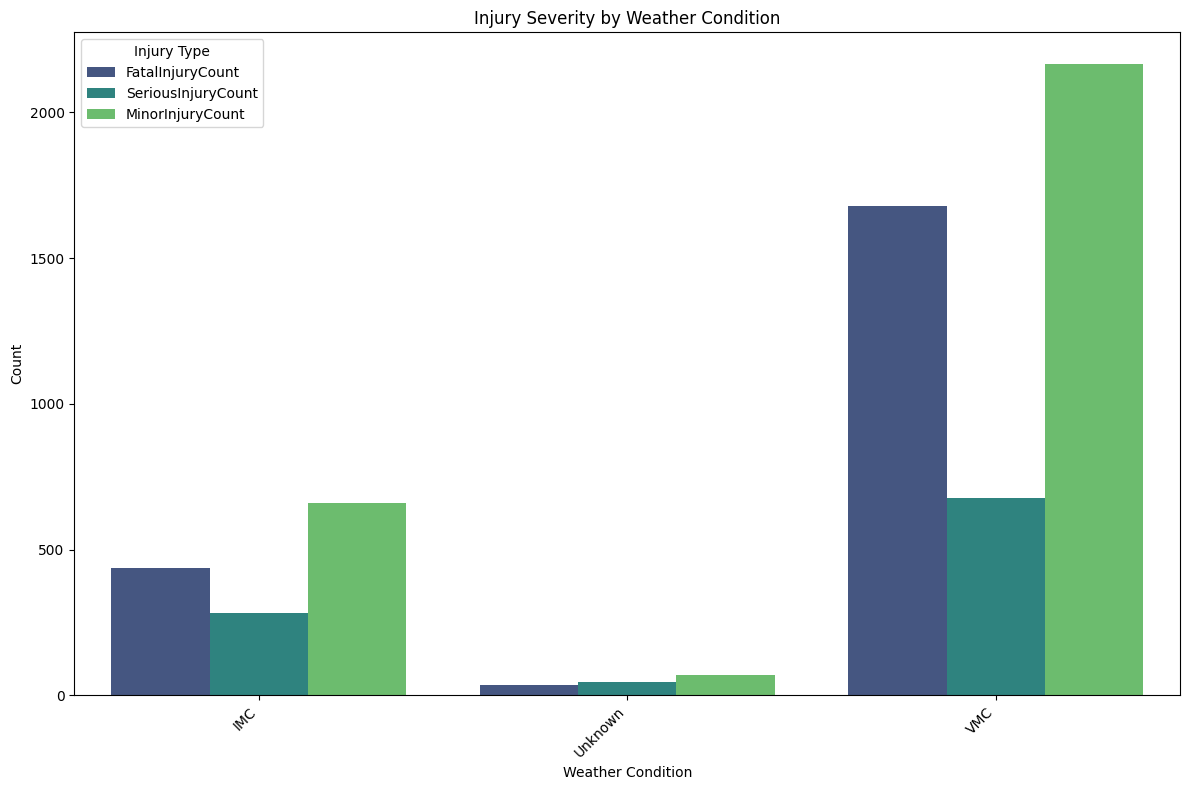

In [14]:
# Clean
df = df.dropna(subset=['WeatherCondition'])
desired_labels = ['Unknown', 'VMC', 'IMC']
weather_counts_filtered = df[df['WeatherCondition'].isin(desired_labels)]

# Calculate
weather_counts = weather_counts_filtered.groupby('WeatherCondition')[['FatalInjuryCount', 'SeriousInjuryCount', 'MinorInjuryCount']].sum().reset_index()
weather_counts_melted = weather_counts.melt(id_vars='WeatherCondition', var_name='InjuryType', value_name='Count')
weather_counts_melted = weather_counts_melted[(weather_counts_melted[['Count']] != 0).any(axis=1)]
weather_counts_melted['InjuryType'] = pd.Categorical(weather_counts_melted['InjuryType'], categories=['FatalInjuryCount', 'SeriousInjuryCount', 'MinorInjuryCount'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=weather_counts_melted, x='WeatherCondition', y='Count', hue='InjuryType', palette='viridis')
plt.title('Injury Severity by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Injury Type')
plt.tight_layout()
plt.show()

Here we can see that weather does not have much of a bearing on the severity of an accident. Neither VMC or IMC increase a person's chances of serious or fatal injuries. VMC is also the most common weather condition, and severe IMC tends to result in less accidents because planes are grounded in severe IMC. A plane is routed around or told to land during severe IMC. In addition, improvements in meteological science have had a direct decreasing effect on IMC accidents because onboard instruments can now detect catastrophic weather events (such as microbursts) in time for pilots to avoid them.

## **Problem 3**
**Prediction of Accidents in the Future**

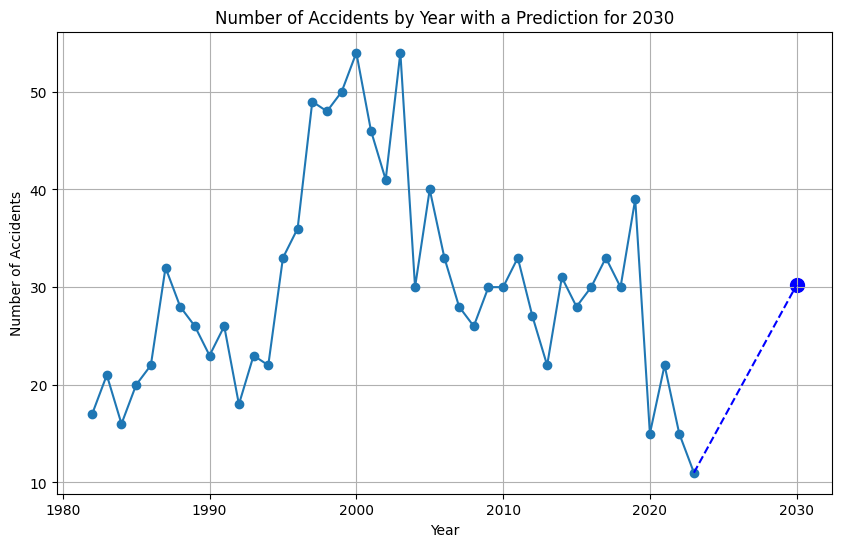

In [15]:
# Fit the linear regression model
model = sm.OLS(accidents_df['Accidents'], sm.add_constant(accidents_df['Year'])).fit()

# Predict accidents for the year 2030
predicted_accidents_2030 = model.predict([1, 2030])[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(accidents_df['Year'], accidents_df['Accidents'], marker='o', linestyle='-')
plt.scatter(2030, predicted_accidents_2030, color='blue', s=100)
plt.plot([accidents_df['Year'].iloc[-1], 2030], [accidents_df['Accidents'].iloc[-1], predicted_accidents_2030], color='blue', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents by Year with a Prediction for 2030')
plt.grid(True)
plt.show()

Here we can see, that it is predicted that the number of accidents will increase between 2023 and 2030 based on historical data patterns. The prediction shows a potential peak in 2030 mirroring the historical low-peak-low cycle.

## **Problem 4**
**Time Between Accident and Investigation Completion by Severity**

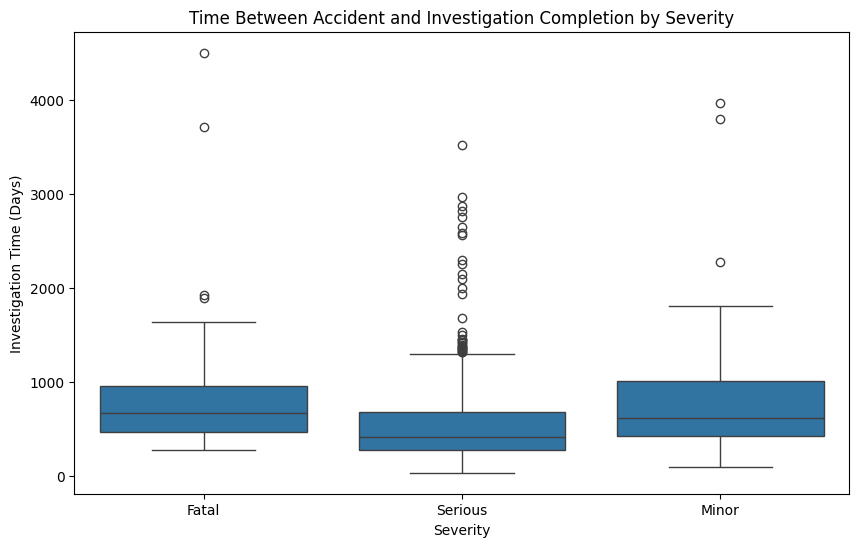

In [16]:
# Clean
df['EventDate'] = pd.to_datetime(df['EventDate']).dt.tz_localize(None)
df['OriginalPublishDate'] = pd.to_datetime(df['OriginalPublishDate']).dt.tz_localize(None)

# Calculate
df['InvestigationTime'] = (df['OriginalPublishDate'] - df['EventDate']).dt.days  # Convert to days for better visualization
df.dropna(subset=['HighestInjuryLevel'], inplace=True)
largest_outlier_index = df['InvestigationTime'].idxmax()
df = df.drop(index=largest_outlier_index)

# Plotting
plt.figure(figsize=(10, 6))
severity_order = ['Fatal', 'Serious', 'Minor']
sns.boxplot(data=df, x='HighestInjuryLevel', y='InvestigationTime', order=severity_order)
plt.title('Time Between Accident and Investigation Completion by Severity')
plt.xlabel('Severity')
plt.ylabel('Investigation Time (Days)')
plt.show()


Here we can see that Fatal accidents tend to have longer investigations. Likely, it can be assumed that these investigations are more difficult because the victims cannot tell investigators what happened.

**Time Between Accident and Investigation Completion by Airline**

<ipython-input-17-d2474c54030d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['EventDate'] = pd.to_datetime(df_filtered['EventDate'])
<ipython-input-17-d2474c54030d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['OriginalPublishDate'] = pd.to_datetime(df_filtered['OriginalPublishDate'])
<ipython-input-17-d2474c54030d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

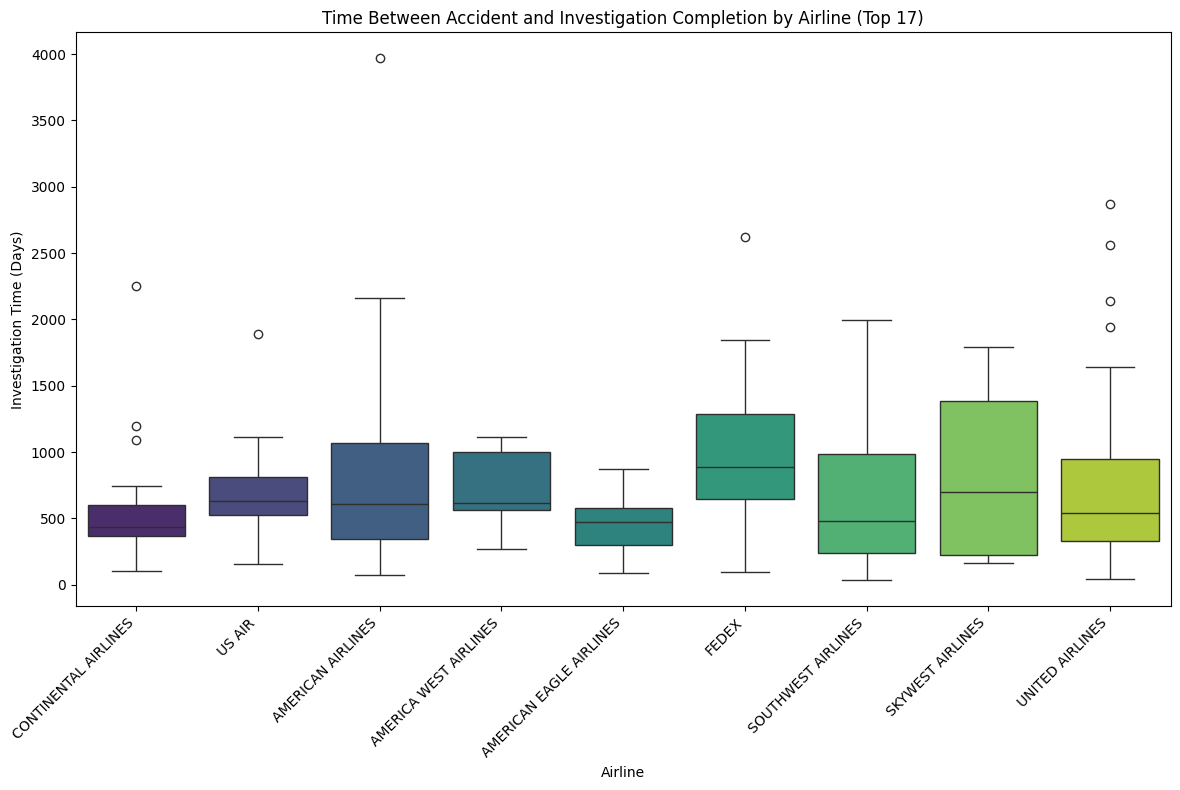

In [17]:
#Define Criteria
top_airlines = ['AMERICA WEST AIRLINES', 'SKYWEST AIRLINES', 'AMERICAN EAGLE AIRLINES', 'US AIR', 'FEDEX', 'CONTINENTAL AIRLINES', 'SOUTHWEST AIRLINES', 'DELTA AIR LINES', 'UNITED AIRLINES', 'AMERICAN AIRLINES']
df_filtered = df[df['Operator'].isin(top_airlines)]

# Clean
df_filtered['EventDate'] = pd.to_datetime(df_filtered['EventDate'])
df_filtered['OriginalPublishDate'] = pd.to_datetime(df_filtered['OriginalPublishDate'])
df_filtered['InvestigationTime'] = (df_filtered['OriginalPublishDate'] - df_filtered['EventDate']).dt.days  # Convert to days for better visualization

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='Operator', y='InvestigationTime', palette='viridis')
plt.title('Time Between Accident and Investigation Completion by Airline (Top 17)')
plt.xlabel('Airline')
plt.ylabel('Investigation Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Fedex has the highest median investigation completion time. Part of this can be seen in that, unlike the other airlines, Fedex does not transport passengers. Hence the witnesses are generally fewer and thus eyewitness information is limited.

**Time Between Accident and Investigation Completion by Aircraft Make**

<ipython-input-18-cef11d395b52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['EventDate'] = pd.to_datetime(df_filtered['EventDate'])
<ipython-input-18-cef11d395b52>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['OriginalPublishDate'] = pd.to_datetime(df_filtered['OriginalPublishDate'])
<ipython-input-18-cef11d395b52>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

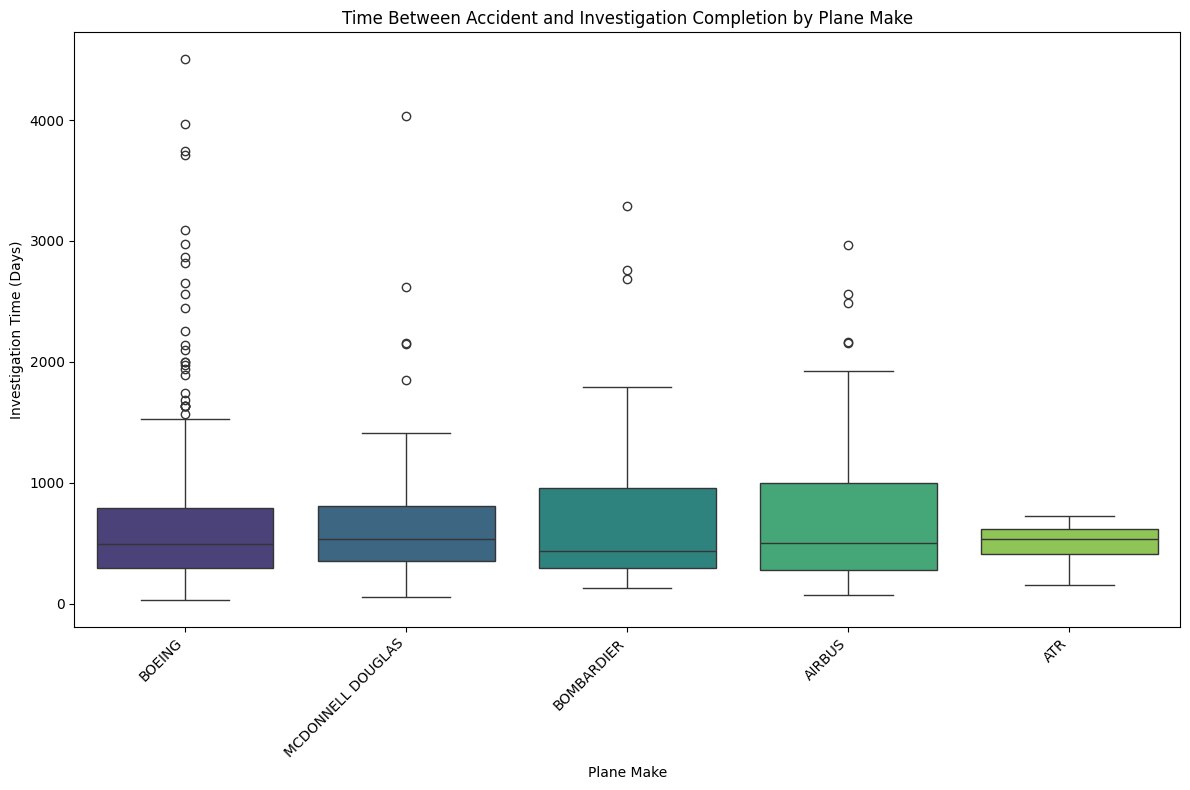

In [18]:
# Define Criteria
specified_plane_makes = ['AIRBUS', 'ATR', 'BOEING', 'BOMBARDIER', 'MCDONNELL DOUGLAS']
df_filtered = df[df['Make'].isin(specified_plane_makes)]

# Clean
df_filtered['EventDate'] = pd.to_datetime(df_filtered['EventDate'])
df_filtered['OriginalPublishDate'] = pd.to_datetime(df_filtered['OriginalPublishDate'])

# Calculate
df_filtered['InvestigationTime'] = (df_filtered['OriginalPublishDate'] - df_filtered['EventDate']).dt.days  # Convert to days for better visualization

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='Make', y='InvestigationTime', palette='viridis')
plt.title('Time Between Accident and Investigation Completion by Plane Make')
plt.xlabel('Plane Make')
plt.ylabel('Investigation Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The make of the plane appears to have a negligble effect on investigation times. Part of the reason for this is the standardization of the "Black Box" technology which is the most vital part of air accident investigations. The "Black Box" is made of the Flight Data Recorder (FDR) which records all the data input into the plane by the pilots and the Cockpit Voice Recorder (CVR) which records the conversations, audio warnings, and other sounds of the cockpit. These are standard accross the world, with extremely strict regulations, meaning once recovered they provide the majority of information investigators might need.

**Time Between Accident and Investigation Completion by Location**

<ipython-input-19-c98410352683>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='State', y='InvestigationTime', palette='viridis')


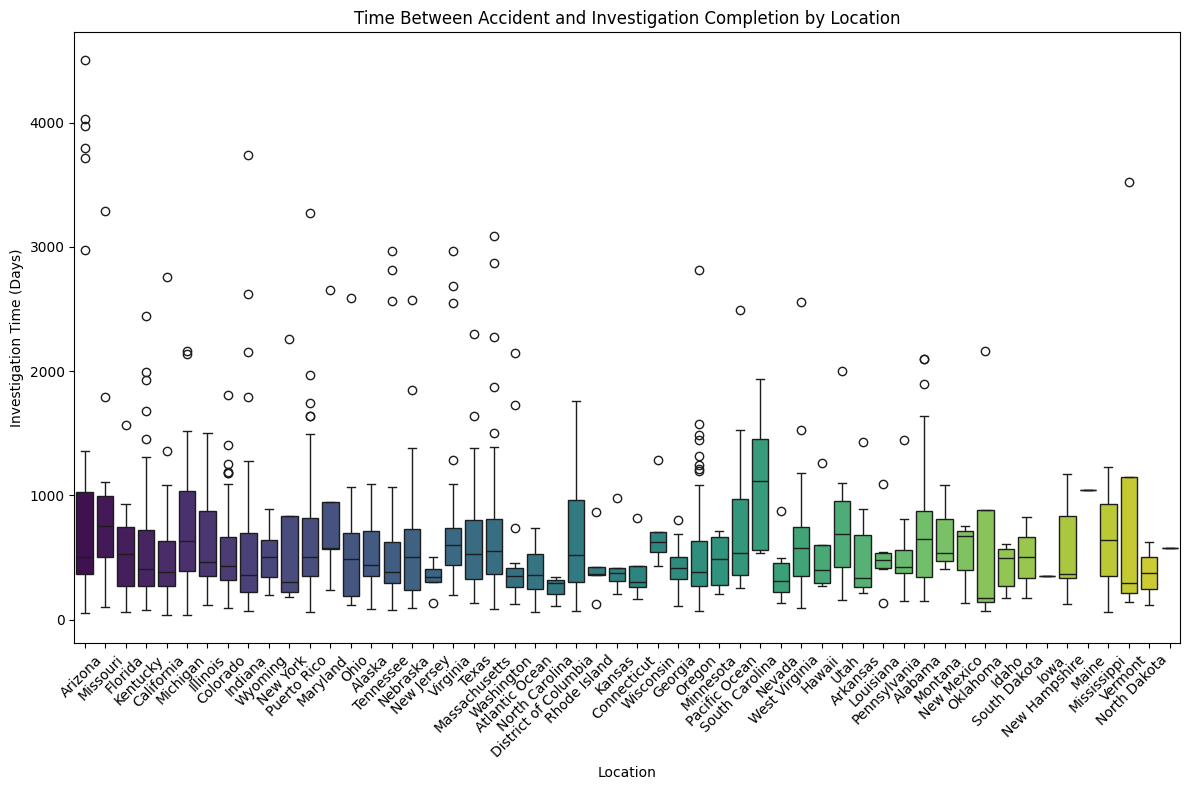

In [19]:
# Clean
df['EventDate'] = pd.to_datetime(df['EventDate'])
df['OriginalPublishDate'] = pd.to_datetime(df['OriginalPublishDate'])
df['InvestigationTime'] = (df['OriginalPublishDate'] - df['EventDate']).dt.days  # Convert to days for better visualization
df_filtered = df.dropna(subset=['State'])
largest_outlier_index = df_filtered['InvestigationTime'].idxmax()
df_filtered = df_filtered.drop(index=largest_outlier_index)

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='State', y='InvestigationTime', palette='viridis')
plt.title('Time Between Accident and Investigation Completion by Location')
plt.xlabel('Location')
plt.ylabel('Investigation Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



As makes logical sense, ocean incidents take the most time to investigate.

**Time Between Accident and Investigation Completion by Weather**

<ipython-input-20-6aa32dbf29ae>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='WeatherCondition', y='InvestigationTime', palette='viridis')


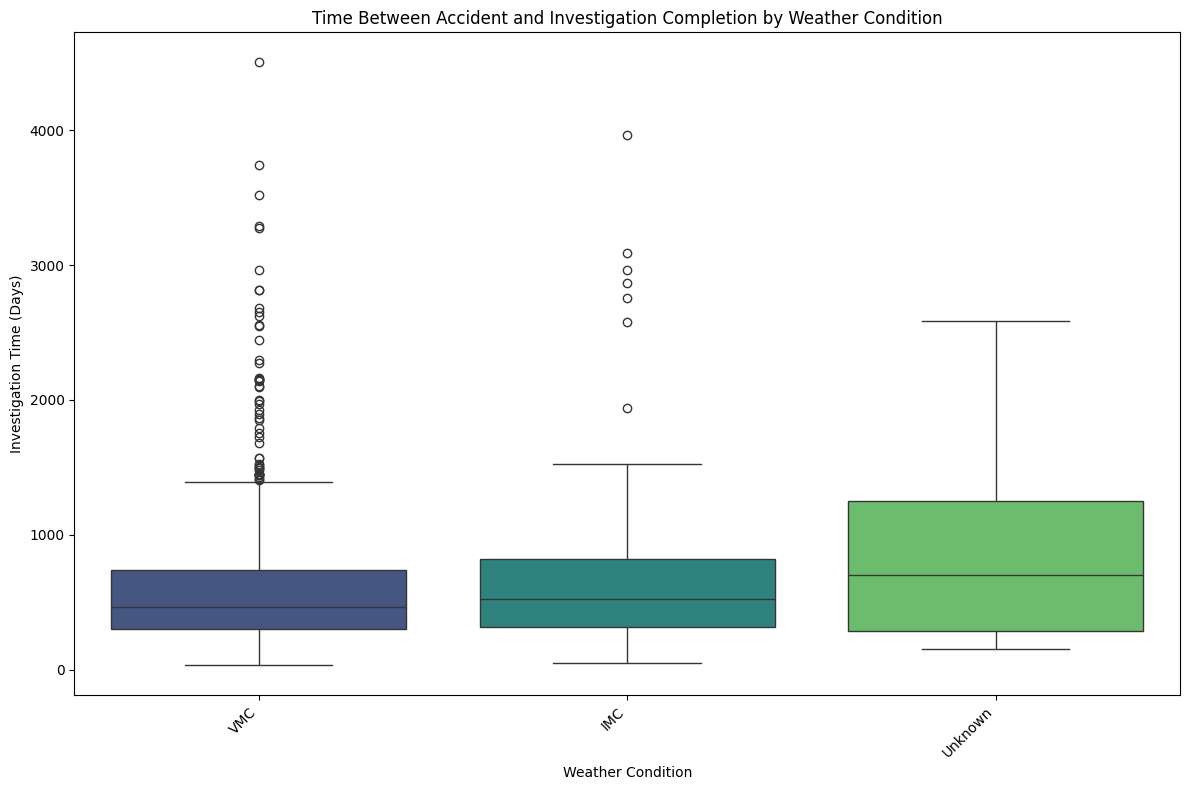

In [20]:

# Convert 'EventDate' and 'OriginalPublishDate' columns to datetime format
df['EventDate'] = pd.to_datetime(df['EventDate'])
df['OriginalPublishDate'] = pd.to_datetime(df['OriginalPublishDate'])

# Calculate the time difference between 'EventDate' and 'OriginalPublishDate' to get investigation completion time
df['InvestigationTime'] = (df['OriginalPublishDate'] - df['EventDate']).dt.days  # Convert to days for better visualization

# Remove rows with blank or unspecified weather conditions
df_filtered = df[df['WeatherCondition'].isin(['VMC', 'IMC', 'Unknown'])]

# Identify the row with the largest investigation time (largest outlier)
largest_outlier_index = df_filtered['InvestigationTime'].idxmax()

# Remove the row with the largest outlier
df_filtered = df_filtered.drop(index=largest_outlier_index)

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='WeatherCondition', y='InvestigationTime', palette='viridis')
plt.title('Time Between Accident and Investigation Completion by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Investigation Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Weather does not appear to have a bearing on investigation completion.

## **Conclusion**

In conclusion, there are many factors influencing the safety of commercial air travel. We hope that the analysis done in this presentation will be helpful for consumers when deciding where, when, what airline, and what aircraft make to choose when deciding to fly in the future.

## **Works Cited**
[1]"Who We Are and What We Do," NTSB.gov, 2023. [Online]. Avaliable: https://www.ntsb.gov/Pages/home.aspx. [Accessed Feb. 22, 2024]

[2]"Regularly Scheduled Air Carriers (Part 121),"faa.gov, 2023. [Online]Avaliable: https://www.faa.gov/hazmat/air_carriers/operations/part_121.[Accessed Feb. 22, 2024]

[3]"Case Analysis and Reporting Online," carol.ntsb.gov, 2023. [Online]. Avaliable: https://carol.ntsb.gov/. [Accessed Feb. 22, 2024]

[4]"NTSB Dataset," docs.google.com, 2023. [Online]. Avaliable: https://docs.google.com/spreadsheets/d/1kyd3T7N7QrAQ6UDe9sLYgMo8dvDdxu8ZUbcS6W2sA3Q/. [Accessed Feb. 22, 2024]